In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
from tqdm import tqdm
import requests
import shutil
import dlib
from facenet_pytorch import InceptionResnetV1
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# 데이터 불러오기

train_folder = os.listdir('/home/minseo/jupyter_dir/Opensourceprogramming/afhq/train/')
len(train_folder)
test_folder = os.listdir('/home/minseo/jupyter_dir/Opensourceprogramming/afhq/val/')
len(train_folder)

In [2]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# 이미지 변환 설정
IMG_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 이미지를 텐서로 변환
    # 여기에 필요한 추가 변환을 추가하세요.
])

# 훈련 데이터셋 로드
train_imgfolder = ImageFolder(root='/home/minseo/jupyter_dir/Opensourceprogramming/afhq/train',
                              transform=IMG_TRANSFORM)

# 테스트 데이터셋 로드
test_imgfolder = ImageFolder(root='/home/minseo/jupyter_dir/Opensourceprogramming/afhq/val',
                             transform=IMG_TRANSFORM)

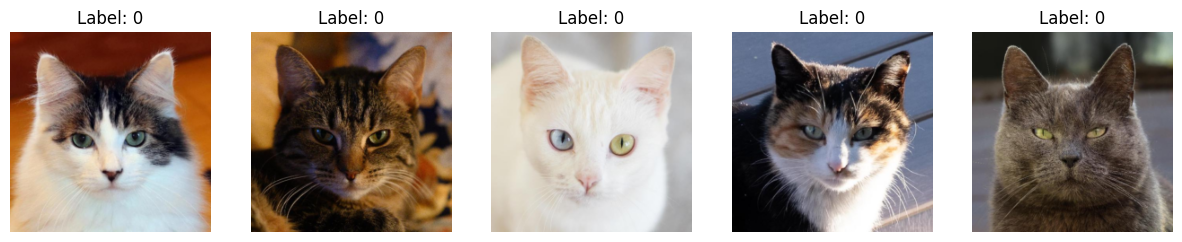

In [3]:
## 데이터 로드 확인 코드

import matplotlib.pyplot as plt

def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, (image, label) in enumerate(dataset):
        if i == num_images:
            break
        ax = axes[i]
        ax.imshow(image.permute(1, 2, 0))  # CHW -> HWC
        ax.axis('off')
        ax.set_title(f"Label: {label}")

# 훈련 데이터셋에서 샘플 이미지 보기
show_sample_images(test_imgfolder)


In [4]:
## 레이블링 확인 코드

import numpy as np

# 레이블 분포 확인
train_labels = np.array([label for _, label in train_imgfolder])
test_labels = np.array([label for _, label in test_imgfolder])

print("훈련 데이터셋 레이블 분포:", np.unique(train_labels, return_counts=True))
print("테스트 데이터셋 레이블 분포:", np.unique(test_labels, return_counts=True))


훈련 데이터셋 레이블 분포: (array([0, 1, 2]), array([5153, 4739, 4738]))
테스트 데이터셋 레이블 분포: (array([0, 1, 2]), array([500, 500, 500]))


In [5]:
from torch.utils.data import DataLoader, Subset
# 라벨이 0과 1인 데이터의 인덱스를 찾는 함수
def get_indices(dataset, labels=[0, 1]):
    indices = []
    for idx, (_, label) in enumerate(dataset):
        if label in labels:
            indices.append(idx)
    return indices

In [6]:
# 라벨이 0과 1인 훈련 데이터의 인덱스
train_indices = get_indices(train_imgfolder)

# 라벨이 0과 1인 테스트 데이터의 인덱스
test_indices = get_indices(test_imgfolder)

In [7]:
import os
# Subset을 사용하여 선택된 인덱스의 데이터만 포함하는 DataLoader 생성
train_dataloader = DataLoader(
    dataset=Subset(train_imgfolder, train_indices),
    batch_size=32, 
    num_workers=os.cpu_count(), 
    shuffle=True)

test_dataloader = DataLoader(
    dataset=Subset(test_imgfolder, test_indices),
    batch_size=32, 
    num_workers=os.cpu_count(), 
    shuffle=False)

## FaceNet(Trained) 얼굴 인식 임베딩 설치

## 데이터 임베딩


In [9]:
# 모델 인스턴스 생성 (필요한 경우)
model = InceptionResnetV1(pretrained=None, num_classes=2)

# 모델의 분류 레이어 교체 (동물 종류 수에 맞게 조정)
model.logits = nn.Linear(model.last_linear.in_features, 2)

# 상태 사전 로드
model.load_state_dict(torch.load('animal_model_state_dict.pth'))

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 device로 이동
model = model.to(device)

In [10]:
def extract_embeddings(loader, model):
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for i, (images, target) in enumerate(loader):
            images = images.to(device)
            emb = model(images)
            embeddings.append(emb.cpu().numpy())
            labels.append(target.numpy())
    
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

In [11]:
X_train, Y_train = extract_embeddings(train_dataloader, model)
X_test, Y_test = extract_embeddings(test_dataloader, model)

## 모델 정의

- 입력 : 얼굴 임베딩 벡터
- 출력 : 분류된 라벨

import torch
import torch.nn as nn
import torch.optim as optim

# 분류 모델 클래스 정의
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [12]:
import torch 
import torch.nn as nn 
import torch.optim as optim

class ModifiedClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ModifiedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)  # 추가 은닉층
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout(out)  # 드롭아웃 적용
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


## 학습

# 트레인 데이터 준비

# 임베딩과 레이블에서 None 값을 제거하고 임베딩 벡터만 추출
filtered_train_x_data = []
filtered_train_y_data = []

for emb, label in zip(train_x_data, train_y_data):
    if emb is not None:
        # 임베딩 벡터 추출
        emb_vector = emb[0]['embedding']  # 첫 번째 항목의 'embedding' 키에 해당하는 값
        filtered_train_x_data.append(emb_vector)
        filtered_train_y_data.append(label)

# 리스트를 텐서로 변환
x_train = torch.tensor(filtered_train_x_data, dtype=torch.float32)
y_train = torch.tensor(filtered_train_y_data, dtype=torch.long)

In [13]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)

In [14]:
# 모델 인스턴스 생성
input_size = X_train.shape[1]  # 임베딩 벡터의 크기
hidden_size = 256  # 은닉층 크기
num_classes = 2  # 클래스 수 (강아지, 고양이)
model = ModifiedClassifier(input_size, hidden_size, num_classes)

# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 루프
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 모델 저장
torch.save(model.state_dict(), 'model.pth')

print("모델 훈련 완료")

Epoch [10/100], Loss: 0.6356
Epoch [20/100], Loss: 0.4618
Epoch [30/100], Loss: 0.2055
Epoch [40/100], Loss: 0.0479
Epoch [50/100], Loss: 0.0103
Epoch [60/100], Loss: 0.0034
Epoch [70/100], Loss: 0.0018
Epoch [80/100], Loss: 0.0012
Epoch [90/100], Loss: 0.0009
Epoch [100/100], Loss: 0.0007
모델 훈련 완료


# 테스트 지표확인

# 테스트 데이터 준비

# 임베딩과 레이블에서 None 값을 제거하고 임베딩 벡터만 추출
filtered_test_x_data = []
filtered_test_y_data = []

for emb, label in zip(test_x_data, test_y_data):
    if emb is not None:
        # 임베딩 벡터 추출
        emb_vector = emb[0]['embedding']  # 첫 번째 항목의 'embedding' 키에 해당하는 값
        filtered_test_x_data.append(emb_vector)
        filtered_test_y_data.append(label)

# 리스트를 텐서로 변환
x_test = torch.tensor(filtered_test_x_data, dtype=torch.float32)
y_test = torch.tensor(filtered_test_y_data, dtype=torch.long)

In [15]:
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

In [17]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report

# 모델 불러오기 (학습된 모델의 가중치를 불러옵니다)
model = ModifiedClassifier(input_size, hidden_size, num_classes)  # Classifier는 앞서 정의한 모델 클래스
model.load_state_dict(torch.load('model.pth'))
model.eval()  # 모델을 평가 모드로 설정

# 테스트 루프
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    total += Y_test.size(0)  # 레이블의 개수만큼 total을 증가시킴
    correct += (predicted == Y_test).sum().item()

    all_labels.extend(Y_test.cpu().numpy())
    all_preds.extend(predicted.cpu().numpy())

# 평가 지표 계산
if total > 0:
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy}%')
else:
    print("테스트 데이터가 없습니다.")

# 혼동 행렬과 분류 보고서
print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds))


Accuracy of the model on the test images: 99.9%
[[499   1]
 [  0 500]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



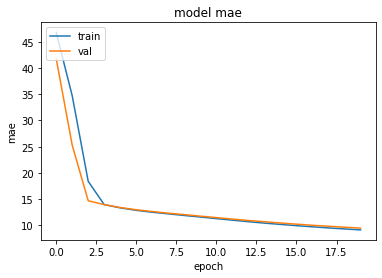

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()